In [ ]:
# Cell 1 - Install dependencies
!pip -q install "numpy<2.3" yfinance pandas scikit-learn matplotlib \
                 torch xgboost stable-baselines3 gymnasium shimmy seaborn

import warnings, gc, os, pathlib, pickle
import numpy as np, pandas as pd, matplotlib.pyplot as plt
warnings.filterwarnings("ignore", category=FutureWarning)

import torch
from tqdm.auto import tqdm
from sklearn.preprocessing import MinMaxScaler
from sklearn.covariance import LedoitWolf
from sklearn.metrics import (mean_absolute_error, mean_squared_error, r2_score,
                             accuracy_score, confusion_matrix, classification_report)
import yfinance as yf
from stable_baselines3 import PPO
from stable_baselines3.common.env_util import make_vec_env
import gymnasium as gym
from xgboost import XGBClassifier
import seaborn as sns

def release_memory():
    gc.collect()
    if torch.cuda.is_available():
        torch.cuda.empty_cache()
    print("🧹 Memory released.")


In [ ]:
# Cell 2 - Config
START, END = "2010-01-01", "2024-12-31"
TICKERS    = {"AAPL":"AAPL", "EURUSD":"EURUSD=X", "GOLD":"GC=F"}

device = "cuda" if torch.cuda.is_available() else "cpu"
print("✅ Device:", device)


✅ Device: cuda


In [ ]:
# Cell 3 - Prices & Returns
price_frames = []
for name, ticker in TICKERS.items():
    df = yf.download(ticker, start=START, end=END, progress=False)[["Close"]]
    df.rename(columns={"Close": f"{name}_Close"}, inplace=True)
    price_frames.append(df)

prices = pd.concat(price_frames, axis=1).dropna()# Proper flatten: combine levels into single string
prices.columns = [f"{a}_{b}" if b != "" else a for a, b in prices.columns]
rets.columns   = [f"{a}_{b}" if b != "" else a for a, b in rets.columns]

print("Merged prices:", prices.shape)
print(prices.head())
print("\nReturns:", rets.shape)
print(rets.head())



Merged prices: (3765, 3)
            AAPL_Close_AAPL  EURUSD_Close_EURUSD=X  GOLD_Close_GC=F
Date                                                               
2010-01-04         6.424605               1.442398      1117.699951
2010-01-05         6.435713               1.436596      1118.099976
2010-01-06         6.333344               1.440403      1135.900024
2010-01-07         6.321634               1.431803      1133.099976
2010-01-08         6.363664               1.441109      1138.199951

Returns: (3764, 3)
            AAPL_Close_AAPL  EURUSD_Close_EURUSD=X  GOLD_Close_GC=F
Date                                                               
2010-01-05         0.001727              -0.004031         0.000358
2010-01-06        -0.016034               0.002647         0.015795
2010-01-07        -0.001851              -0.005989        -0.002468
2010-01-08         0.006626               0.006478         0.004491
2010-01-11        -0.008860               0.006927         0.010922


In [ ]:
# Cell 4 - Features (no sentiment)
window = 30
rets_arr = rets.values
covs = []
lw = LedoitWolf()
for i in range(window, len(rets_arr)):
    covs.append(lw.fit(rets_arr[i-window:i]).covariance_)
covs = np.array(covs, dtype="float32")

# Simple moving averages as features
ma_fast = prices.rolling(10).mean()
ma_slow = prices.rolling(50).mean()
ma_feat = (ma_fast / ma_slow - 1).dropna()

# Align all features
X = ma_feat.iloc[window:].copy()
y = rets.iloc[window:].copy()
print("Features:", X.shape, "Targets:", y.shape)


Features: (3686, 3) Targets: (3734, 3)


In [ ]:
# CELL: Robust feature build + XGBoost training per asset
# Assumes 'prices' and 'rets' exist (DataFrames) already computed in earlier cells.

import numpy as np
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score

SEED = 42

# 1) Flatten MultiIndex columns if present (safe idempotent)
def flatten_cols(df):
    cols = []
    for c in df.columns:
        if isinstance(c, tuple):
            # join with underscore, remove empty pieces
            cols.append("_".join([str(x) for x in c if x != ""]))
        else:
            cols.append(str(c))
    df.columns = cols
    return df

prices = flatten_cols(prices.copy())
rets   = flatten_cols(rets.copy())

print("After flattening, price cols:", list(prices.columns))
print("After flattening, return cols:", list(rets.columns))

# 2) Build features (lag returns, rolling vol, MA ratio) and DROP rows with any NaN
feat = pd.DataFrame(index=rets.index)

for pcol in prices.columns:
    # find matching returns column (we expect names to share prefix like 'AAPL_Close' etc.)
    # Here we assume pcol and returns column have same prefix; if not, user should adapt naming.
    # Use exact matching where possible:
    if pcol in rets.columns:
        ret_col = pcol
    else:
        # fallback: try match by asset prefix (part before first underscore)
        prefix = pcol.split("_")[0]
        matches = [c for c in rets.columns if c.startswith(prefix)]
        ret_col = matches[0] if matches else None

    # if we have a matching return column, create features
    if ret_col is None:
        # skip if can't match
        continue

    # lag-1 return
    feat[f"{ret_col}_r1"] = rets[ret_col].shift(1)

    # rolling volatility (20 days)
    feat[f"{ret_col}_vol20"] = rets[ret_col].rolling(20).std().shift(1)

    # MA ratio (fast=10 / slow=50) computed on prices; shift(1) so it's based on past
    ma_fast = prices[pcol].rolling(10).mean().shift(1)
    ma_slow = prices[pcol].rolling(50).mean().shift(1)
    feat[f"{ret_col}_ma10_50"] = (ma_fast / ma_slow - 1.0)

# drop rows with any NaN (these come from initial windows)
feat = feat.dropna(how='any')
print("Feature matrix shape (after dropna):", feat.shape)

# 3) Train a classifier per asset (aligned to features.index)
results = {}
for asset_col in rets.columns:
    # Next-day return = label source
    r_next = rets[asset_col].shift(-1).reindex(feat.index)

    # compute volatility-based threshold per day to keep labels adaptive
    vol = rets[asset_col].rolling(20).std().reindex(feat.index).bfill().values
    tau = 0.25 * vol  # tau per-day

    # Label mapping: 0=Down, 1=Flat, 2=Up
    y = pd.Series(1, index=feat.index, dtype=int)
    y[r_next < -tau] = 0
    y[r_next >  tau] = 2

    # drop any locations where r_next is NaN (edge of series)
    valid_mask = r_next.notna()
    X_train = feat.loc[valid_mask, :].copy()
    y_train = y.loc[valid_mask].astype(int).copy()

    # Safety checks
    assert len(X_train) == len(y_train), f"Length mismatch for {asset_col}: X={len(X_train)} y={len(y_train)}"
    print(f"\nTraining for {asset_col} | X.shape={X_train.shape} | y.shape={y_train.shape}")
    unique, counts = np.unique(y_train.values, return_counts=True)
    print("  class dist:", dict(zip(unique, counts)))

    if len(y_train) < 50:
        print("  Skipping - too few training samples.")
        continue

    # Train XGBoost (multiclass: 3 classes)
    clf = XGBClassifier(
        objective="multi:softprob",
        num_class=3,
        n_estimators=150,
        max_depth=3,
        random_state=SEED,
        use_label_encoder=False,
        eval_metric="mlogloss",
        tree_method="hist"
    )
    clf.fit(X_train.values, y_train.values)

    preds = clf.predict(X_train.values)
    acc = accuracy_score(y_train.values, preds)
    print(f"  Trained {asset_col} | training accuracy: {acc:.4f}")

    results[asset_col] = {"clf": clf, "acc": acc, "X_index": X_train.index}

print("\nAll done. results keys:", list(results.keys()))


After flattening, price cols: ['AAPL_Close_AAPL', 'EURUSD_Close_EURUSD=X', 'GOLD_Close_GC=F']
After flattening, return cols: ['AAPL_Close_AAPL', 'EURUSD_Close_EURUSD=X', 'GOLD_Close_GC=F']
Feature matrix shape (after dropna): (3715, 9)

Training for AAPL_Close_AAPL | X.shape=(3714, 9) | y.shape=(3714,)
  class dist: {np.int64(0): np.int64(1303), np.int64(1): np.int64(854), np.int64(2): np.int64(1557)}
  Trained AAPL_Close_AAPL | training accuracy: 0.7725

Training for EURUSD_Close_EURUSD=X | X.shape=(3714, 9) | y.shape=(3714,)
  class dist: {np.int64(0): np.int64(1487), np.int64(1): np.int64(755), np.int64(2): np.int64(1472)}
  Trained EURUSD_Close_EURUSD=X | training accuracy: 0.7803

Training for GOLD_Close_GC=F | X.shape=(3714, 9) | y.shape=(3714,)
  class dist: {np.int64(0): np.int64(1319), np.int64(1): np.int64(900), np.int64(2): np.int64(1495)}
  Trained GOLD_Close_GC=F | training accuracy: 0.7628

All done. results keys: ['AAPL_Close_AAPL', 'EURUSD_Close_EURUSD=X', 'GOLD_Close_G

In [ ]:
print("feat index min/max:", feat.index.min(), feat.index.max())
print("rets index min/max:", rets.index.min(), rets.index.max())
print("len feat, len rets:", len(feat), len(rets))


feat index min/max: 2010-03-17 00:00:00 2024-12-30 00:00:00
rets index min/max: 2010-01-05 00:00:00 2024-12-30 00:00:00
len feat, len rets: 3715 3764


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

# We will split features/labels per asset consistently
eval_results = {}

for asset_col, res in results.items():
    clf = res["clf"]

    # Build full aligned dataset again
    r_next = rets[asset_col].shift(-1).reindex(feat.index)
    vol = rets[asset_col].rolling(20).std().reindex(feat.index).bfill().values
    tau = 0.25 * vol
    y = pd.Series(1, index=feat.index, dtype=int)
    y[r_next < -tau] = 0
    y[r_next >  tau] = 2
    valid_mask = r_next.notna()
    X_all = feat.loc[valid_mask, :]
    y_all = y.loc[valid_mask]

    # Split train/test by time (80% train, 20% test)
    split = int(len(X_all) * 0.8)
    X_train, X_test = X_all.iloc[:split], X_all.iloc[split:]
    y_train, y_test = y_all.iloc[:split], y_all.iloc[split:]

    preds_train = clf.predict(X_train.values)
    preds_test  = clf.predict(X_test.values)

    print(f"\n📊 Asset: {asset_col}")
    print("Train accuracy:", accuracy_score(y_train, preds_train))
    print("Test accuracy :", accuracy_score(y_test, preds_test))
    print("\nClassification report (test):\n", classification_report(y_test, preds_test))

    eval_results[asset_col] = {
        "train_acc": accuracy_score(y_train, preds_train),
        "test_acc": accuracy_score(y_test, preds_test)
    }



📊 Asset: AAPL_Close_AAPL
Train accuracy: 0.7744867048131943
Test accuracy : 0.7644683714670256

Classification report (test):
               precision    recall  f1-score   support

           0       0.78      0.78      0.78       276
           1       0.87      0.50      0.63       157
           2       0.73      0.88      0.80       310

    accuracy                           0.76       743
   macro avg       0.79      0.72      0.74       743
weighted avg       0.78      0.76      0.76       743


📊 Asset: EURUSD_Close_EURUSD=X
Train accuracy: 0.7839111410299563
Test accuracy : 0.765814266487214

Classification report (test):
               precision    recall  f1-score   support

           0       0.76      0.85      0.80       301
           1       0.90      0.49      0.64       158
           2       0.74      0.83      0.78       284

    accuracy                           0.77       743
   macro avg       0.80      0.72      0.74       743
weighted avg       0.78      0.7

In [ ]:
# Store directional probabilities per asset for RL
prob_signals = {}

for asset_col, res in results.items():
    clf = res["clf"]

    # Compute class probabilities (Down, Flat, Up) across all dates
    probs = clf.predict_proba(feat.values)
    probs_df = pd.DataFrame(
        probs, index=feat.index, columns=["Down", "Flat", "Up"]
    )
    prob_signals[asset_col] = probs_df

    print(f"\n🔮 Sample probabilities for {asset_col}:")
    print(probs_df.head())



🔮 Sample probabilities for AAPL_Close_AAPL:
                Down      Flat        Up
Date                                    
2010-03-17  0.290043  0.302941  0.407016
2010-03-18  0.348648  0.251097  0.400256
2010-03-19  0.217138  0.217032  0.565830
2010-03-22  0.316232  0.261958  0.421811
2010-03-23  0.298245  0.167883  0.533872

🔮 Sample probabilities for EURUSD_Close_EURUSD=X:
                Down      Flat        Up
Date                                    
2010-03-17  0.639051  0.072745  0.288204
2010-03-18  0.415908  0.296800  0.287293
2010-03-19  0.456257  0.158135  0.385607
2010-03-22  0.406495  0.242555  0.350950
2010-03-23  0.511563  0.099241  0.389196

🔮 Sample probabilities for GOLD_Close_GC=F:
                Down      Flat        Up
Date                                    
2010-03-17  0.271904  0.360936  0.367161
2010-03-18  0.658504  0.113464  0.228032
2010-03-19  0.630456  0.192245  0.177299
2010-03-22  0.430534  0.198991  0.370475
2010-03-23  0.558084  0.137174  0.30474

In [ ]:
# Build combined state features for RL
state = pd.DataFrame(index=feat.index)

for asset_col in rets.columns:
    # include raw return (lagged) as feature
    state[f"{asset_col}_r1"] = rets[asset_col].shift(1).reindex(feat.index)

    # include rolling volatility
    state[f"{asset_col}_vol20"] = rets[asset_col].rolling(20).std().shift(1).reindex(feat.index)

    # include probability signals
    if asset_col in prob_signals:
        probs = prob_signals[asset_col].reindex(feat.index)
        for c in ["Down","Flat","Up"]:
            state[f"{asset_col}_{c}"] = probs[c]

# Drop NaNs from state
state = state.dropna(how="any")
print("RL state shape:", state.shape)
print(state.head())


RL state shape: (3715, 15)
            AAPL_Close_AAPL_r1  AAPL_Close_AAPL_vol20  AAPL_Close_AAPL_Down  \
Date                                                                          
2010-03-17            0.002721               0.012521              0.290043   
2010-03-18           -0.001471               0.012431              0.348648   
2010-03-19            0.002362               0.012425              0.217138   
2010-03-22           -0.010741               0.012679              0.316232   
2010-03-23            0.011186               0.012475              0.298245   

            AAPL_Close_AAPL_Flat  AAPL_Close_AAPL_Up  \
Date                                                   
2010-03-17              0.302941            0.407016   
2010-03-18              0.251097            0.400256   
2010-03-19              0.217032            0.565830   
2010-03-22              0.261958            0.421811   
2010-03-23              0.167883            0.533872   

            EURUSD_Close_E

In [ ]:
# Align prices with state dates
prices_aligned = prices.reindex(state.index).copy()
rets_aligned   = rets.reindex(state.index).copy()

print("prices_aligned:", prices_aligned.shape)
print("rets_aligned:", rets_aligned.shape)
print("state:", state.shape)


prices_aligned: (3715, 3)
rets_aligned: (3715, 3)
state: (3715, 15)


In [ ]:
# Cell 10 (REPLACEMENT) - Full PortfolioEnv with robust seeding (no .seed() call)
import numpy as np
import gymnasium as gym
from gymnasium import spaces

SEED = globals().get("SEED", 42)
RL_TIMESTEPS = globals().get("RL_TIMESTEPS", 20000)

class PortfolioEnv(gym.Env):
    """
    Full portfolio env:
      - action: allocation vector (non-negative), normalized to sum=1
      - obs: concatenation of state row (features) + previous weights
      - reward: portfolio return net of transaction costs - drawdown penalty - turnover penalty
    """
    metadata = {"render.modes": ["human"]}

    def __init__(self,
                 prices: pd.DataFrame,
                 returns: pd.DataFrame,
                 state_df: pd.DataFrame,
                 tcosts: list | np.ndarray = None,
                 turnover_penalty: float = 0.0,
                 drawdown_lambda: float = 1.0,
                 seed: int | None = None):
        super().__init__()

        # store (we expect DataFrames aligned by index)
        self.prices = prices.reset_index(drop=True).astype(np.float32)
        self.returns = returns.reset_index(drop=True).astype(np.float32)
        # state_df may be DataFrame -- keep copy and values
        if isinstance(state_df, pd.DataFrame):
            self.state = state_df.reset_index(drop=True).astype(np.float32).values
            self._dates = state_df.index
        else:
            self.state = np.asarray(state_df, dtype=np.float32)
            self._dates = None

        assert len(self.state) == len(self.returns) == len(self.prices), \
            f"Alignment error: lengths must match (state {len(self.state)}, rets {len(self.returns)}, prices {len(self.prices)})"

        self.T = len(self.state)
        self.n_assets = self.returns.shape[1]

        # costs & penalties
        if tcosts is None:
            self.tcosts = np.array([0.0005]*self.n_assets, dtype=np.float32)
        else:
            self.tcosts = np.array(tcosts, dtype=np.float32)

        self.turnover_penalty = float(turnover_penalty)
        self.drawdown_lambda = float(drawdown_lambda)

        # observation & action spaces
        obs_dim = self.state.shape[1] + self.n_assets
        self.observation_space = spaces.Box(low=-np.inf, high=np.inf, shape=(obs_dim,), dtype=np.float32)
        self.action_space = spaces.Box(low=0.0, high=1.0, shape=(self.n_assets,), dtype=np.float32)

        # runtime variables
        self.t = 0
        self.w_prev = np.zeros(self.n_assets, dtype=np.float32)
        self.equity = 1.0
        self.equity_series = []
        self.peak = 1.0

        # rng: use gym seeding utility to get a PRNG (works across gym/numpy versions)
        self.np_random, _ = gym.utils.seeding.np_random(seed if seed is not None else SEED)

    def reset(self, *, seed=None, options=None):
        # Do not call .seed() on np_random (may be Generator). Instead reassign via gym seeding util.
        if seed is not None:
            self.np_random, _ = gym.utils.seeding.np_random(seed)

        self.t = 0
        self.w_prev = np.zeros(self.n_assets, dtype=np.float32)
        self.equity = 1.0
        self.equity_series = [self.equity]
        self.peak = self.equity

        obs = np.concatenate([self.state[self.t], self.w_prev]).astype(np.float32)
        return obs, {}

    def step(self, action):
        # sanitize action
        a = np.nan_to_num(action, nan=0.0, posinf=0.0, neginf=0.0).astype(np.float32)
        s = float(a.sum())
        if s <= 1e-8:
            a = np.ones_like(a) / float(len(a))
        else:
            a = a / s

        # realized return vector at t
        r_vec = self.returns.iloc[self.t].values.astype(np.float32)
        r_vec = np.nan_to_num(r_vec, nan=0.0, posinf=0.0, neginf=0.0)

        # gross portfolio return
        gross_ret = float(np.dot(a, r_vec))

        # transaction cost
        turnover = float(np.abs(a - self.w_prev).sum())
        tcost = float(np.dot(self.tcosts, np.abs(a - self.w_prev)))

        # update equity
        net_ret = gross_ret - tcost
        self.equity *= (1.0 + net_ret)
        self.equity_series.append(self.equity)

        # drawdown penalty
        if self.equity > self.peak:
            self.peak = self.equity
        drawdown = (self.peak - self.equity) / (self.peak + 1e-12)
        drawdown_pen = self.drawdown_lambda * drawdown

        # turnover penalty
        turnover_pen = self.turnover_penalty * turnover

        # reward
        reward = net_ret - drawdown_pen - turnover_pen

        # update previous weights
        self.w_prev = a

        # advance time
        self.t += 1
        done = self.t >= (self.T - 1)

        # produce next observation (if done, return last row)
        next_state = self.state[self.t] if not done else self.state[-1]
        obs = np.concatenate([next_state, self.w_prev]).astype(np.float32)

        info = {
            "gross_ret": gross_ret,
            "net_ret": net_ret,
            "tcost": tcost,
            "turnover": turnover,
            "drawdown": drawdown,
            "equity": self.equity
        }

        # Gymnasium expects: obs, reward, terminated, truncated, info
        # SB3 accepts both older and newer formats; return terminated=done, truncated=False
        return obs, float(reward), bool(done), False, info

    def render(self, mode="human"):
        print(f"t={self.t} equity={self.equity:.4f} peak={self.peak:.4f}")


In [ ]:
# Cell 11 (REPLACEMENT) - Train PPO (call this after replacing env above)
from stable_baselines3 import PPO
from stable_baselines3.common.vec_env import DummyVecEnv, VecNormalize
from stable_baselines3.common.env_util import make_vec_env

# hyperparams (tweak if needed)
tcosts = [0.0005, 0.0008, 0.0010]
turnover_penalty = 0.0
drawdown_lambda = 0.5

def make_env_fn():
    def _init():
        return PortfolioEnv(
            prices=prices_aligned,
            returns=rets_aligned,
            state_df=state,
            tcosts=tcosts,
            turnover_penalty=turnover_penalty,
            drawdown_lambda=drawdown_lambda,
            seed=SEED
        )
    return _init

# vectorized env (n_envs=1 for determinism)
vec_env = make_vec_env(make_env_fn(), n_envs=1, seed=SEED)

model = PPO(
    policy="MlpPolicy",
    env=vec_env,
    verbose=1,
    seed=SEED,
    device="auto",
    learning_rate=3e-4,
    n_steps=2048,
    batch_size=512,
    ent_coef=0.0
)

print("🚀 Starting PPO training (short test)...")
# For quick sanity-run set a small number like 2000; change to RL_TIMESTEPS for full train
model.learn(total_timesteps=min(2000, RL_TIMESTEPS))
print("✅ Training finished.")


Using cuda device
🚀 Starting PPO training (short test)...
-----------------------------
| time/              |      |
|    fps             | 640  |
|    iterations      | 1    |
|    time_elapsed    | 3    |
|    total_timesteps | 2048 |
-----------------------------
✅ Training finished.


In [ ]:
# Cell 12 - Evaluate PPO policy
import numpy as np

# Rebuild a fresh environment for evaluation
eval_env = PortfolioEnv(
    prices=prices_aligned,
    returns=rets_aligned,
    state_df=state,
    tcosts=tcosts,
    turnover_penalty=turnover_penalty,
    drawdown_lambda=drawdown_lambda,
    seed=SEED
)

obs, _ = eval_env.reset()
equity_curve = []

for t in range(len(prices_aligned) - 1):
    action, _ = model.predict(obs, deterministic=True)
    obs, reward, done, _, info = eval_env.step(action)
    equity_curve.append(info["equity"])
    if done:
        break

equity_curve = np.array(equity_curve)
dates = prices_aligned.index[:len(equity_curve)]

# Performance metrics
rets_policy = np.diff(np.log(equity_curve + 1e-12))
mean_ret = np.mean(rets_policy)
std_ret = np.std(rets_policy)
sharpe = mean_ret / (std_ret + 1e-8) * np.sqrt(252)   # annualized Sharpe

cum_return = equity_curve[-1] / equity_curve[0] - 1 if len(equity_curve) > 1 else 0
running_max = np.maximum.accumulate(equity_curve)
drawdowns = (running_max - equity_curve) / (running_max + 1e-12)
max_dd = np.max(drawdowns)

print("📊 Policy Evaluation Results")
print(f"Final Equity: {equity_curve[-1]:.3f}")
print(f"Cumulative Return: {cum_return*100:.2f}%")
print(f"Annualized Sharpe: {sharpe:.3f}")
print(f"Max Drawdown: {max_dd*100:.2f}%")


📊 Policy Evaluation Results
Final Equity: 1.863
Cumulative Return: 86.20%
Annualized Sharpe: 0.265
Max Drawdown: 48.69%


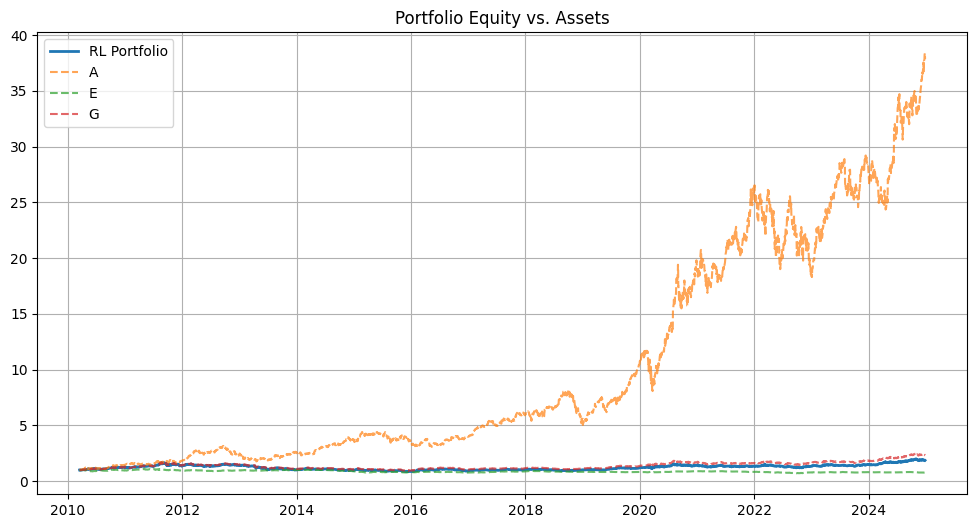

In [ ]:
# Cell 13 - Fixed Plot equity vs assets
plt.figure(figsize=(12,6))
plt.plot(dates, equity_curve, label="RL Portfolio", linewidth=2)

# Compare with individual assets (normalize and align length)
for col in prices_aligned.columns:
    normed = prices_aligned[col] / prices_aligned[col].iloc[0]
    normed = normed.iloc[:len(dates)]   # align to same length as equity_curve
    plt.plot(dates, normed, alpha=0.7, linestyle="--", label=f"{col[0]}")

plt.title("Portfolio Equity vs. Assets")
plt.legend()
plt.grid(True)
plt.show()


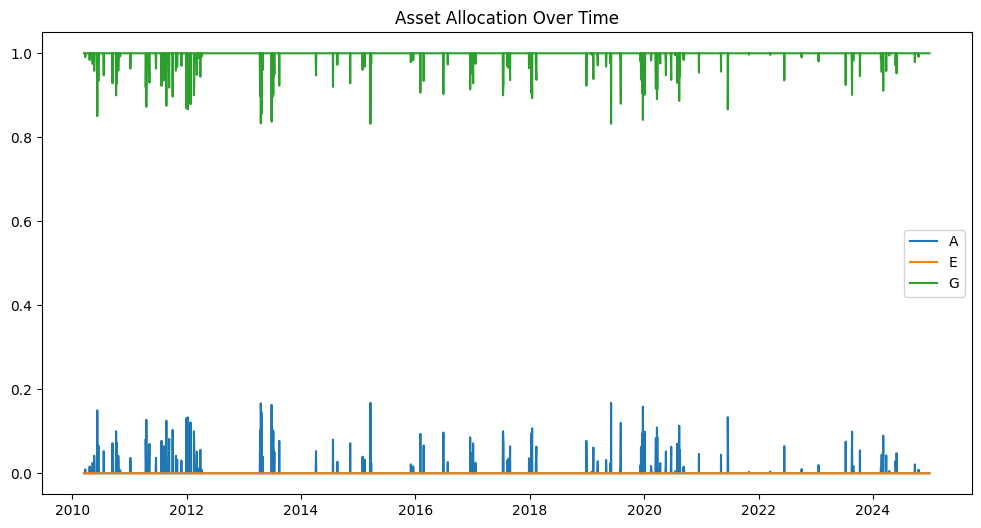

In [ ]:
# Cell 14 - Inspect allocations
allocs = np.array(eval_env.equity_series[1:])  # equity already stored, but not weights
# Instead, store weights during loop:
weights = []
obs, _ = eval_env.reset()
for t in range(len(prices_aligned) - 1):
    action, _ = model.predict(obs, deterministic=True)
    weights.append(action / (np.sum(action) + 1e-8))
    obs, reward, done, _, info = eval_env.step(action)
    if done: break

weights = np.array(weights)
plt.figure(figsize=(12,6))
for i, col in enumerate(prices_aligned.columns):
    plt.plot(dates[:len(weights)], weights[:, i], label=col[0])

plt.title("Asset Allocation Over Time")
plt.legend()
plt.show()
